In [13]:
import os
from dotenv import load_dotenv
from gitdb.fun import chunk_size

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 OpenAI API 키를 가져옵니다.
openai_api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_api_key

# API 키가 존재하지 않는 경우 에러를 발생시킵니다.
if not openai_api_key:
    # API 키가 없다는 에러 메시지를 출력하고 프로그램을 종료합니다.
    raise ValueError("OpenAI API 키가 없습니다. 한 번 더 확인 부탁드립니다.")

In [14]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 크롤링할 웹 페이지 URL 목록
urls = [
    "https://finance.naver.com/",
    "https://finance.yahoo.com/",
    "https://finance.daum.net/",
]

# 각 URL에서 문서 로드
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# 문서 분할 설정
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# 벡터 스토어에 문서 추가
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [15]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [16]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "네이버, 야후, 다음의 금융관련 정보 검색 후 반환" )
tools = [retriever_tool]



In [17]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition


# Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    검색된 문서가 질문과 관련이 있는지 평가합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 문서의 관련성에 따라 다음 노드 결정 ("generate" 또는 "rewrite")
    """
    print("---문서 관련성 평가---")

    # 데이터 모델 정의
    class grade(BaseModel):
        """관련성 평가를 위한 이진 점수."""
        binary_score: str = Field(description="관련성 점수 'yes' 또는 'no'")

    model = ChatOpenAI (temperature=0, model="gpt-4o-mini", streaming=True)

    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""당신은 사용자 질문에 대한 검색된 문서의 관련성을 평가하는 평가자입니다.\n
        여기 검색된 문서가 있습니다:\n\n{context}\n\n
        여기 사용자 질문이 있습니다: {question}\n
        문서가 사용자 질문과 관련된 키워드 또는 의미를 포함하면 관련성이 있다고 평가하세요.\n
        문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 주세요.""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---결정: 문서 관련성 있음---")
        return "generate"

    else:
        print("---결정: 문서 관련성 없음---")
        print(score)
        return "rewrite"

In [18]:
def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다.
    주어진 질문에 따라 검색 도구를 사용하여 검색을 수행하거나 단순히 종료하기로 결정합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """

    print("---에이전트 호출---")
    messages = state["messages"]

    # 메시지 전달여부 확인
    print("에이전트로 전달된 메시지들: ", messages)

    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    model = model.bind_tools(tools)
    response = model.invoke(messages)

    # 응답을 상태에 추가
    state["messages"].append(response)

    return state

In [19]:
def rewrite(state):
    """
    질문을 재작성(변형)하여 더 나은 질문을 생성합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 재구성된 질문으로 업데이트된 상태
    """

    print("---질문 변형---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""다음 입력을 보고 근본적인 의도나 의미를 파악해보세요.\n
            초기 질문은 다음과 같습니다:
            \n-------\n
            {question}
            \n-------\n
            개선된 질문을 만들어주세요:""",
        )
    ]

    # 평가자
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)

    print("Rewrite 단계에서의 응답: " , response)

    state["messages"].append(response)

    return state

In [20]:
def generate(state):
    """
    답변 생성

    Args:
        state (messages): 현재 상태

    Returns:
         dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---생성---")

    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트

    # prompt
    prompt = PromptTemplate(
    template="""당신은 질문-답변 작업을 위한 어시스턴트입니다.
    아래 제공된 문맥을 사용하여 질문에 답변해주세요.
    답을 모를 경우 '모르겠습니다'라고 말해주세요. 답변은 최대 3문장으로 간결하게 작성하세요.

    질문: {question}
    문맥: {context}
    답변: """,
    input_variables=["context", "question"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    rag_chain = prompt | llm  | StrOutputParser()

    response = rag_chain.invoke({"question": question, "context": docs})

    return {"messages": [response]}


In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# 새로운 그래프를 정의합니다.
workflow = StateGraph(AgentState)

# 순환할 노드들을 정의합니다.
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 도구 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node(
    "generate", generate
)  # 문서가 관련성이 있다고 판단된 후 응답 생성 노드
# 에이전트 노드를 호출하여 검색을 결정합니다.
workflow.add_edge(START, "agent")

# 검색 여부를 결정합니다.
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "tools": "retrieve",
        END: "generate",
    },
)

# 검색 후 문서 관련성 평가
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "generate" : "generate",
        "rewrite" : "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 컴파일
graph = workflow.compile()

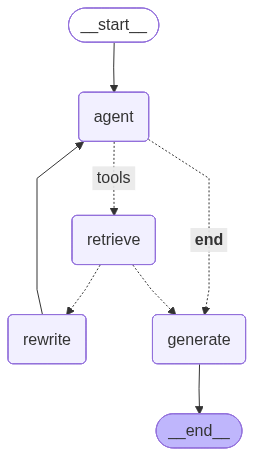

In [22]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [25]:
import pprint

inputs = {
    "messages": [
        ("user", "삼성전자 여자친구?"),
    ]
}

# inputs = {
#     "messages": [
#         ("user", "agentic rag가 어떤의미야?"),
#     ]
# }

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"노드 '{key}'의 출력 결과:")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---에이전트 호출---
에이전트로 전달된 메시지들:  [HumanMessage(content='삼성전자 여자친구?', additional_kwargs={}, response_metadata={}, id='2c8aa3f3-1829-4d2d-aa22-feb3f35fc82f')]
"노드 'agent'의 출력 결과:"
'---'
{ 'messages': [ HumanMessage(content='삼성전자 여자친구?', additional_kwargs={}, response_metadata={}, id='2c8aa3f3-1829-4d2d-aa22-feb3f35fc82f'),
                AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_hHLU4jUwrAmtcjMppSca0yIH', 'function': {'arguments': '{"query":"삼성전자 여자친구"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_2d82c05f26'}, id='run-2c51c466-2f1d-406f-ad64-23e2765bf7c9-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '삼성전자 여자친구'}, 'id': 'call_hHLU4jUwrAmtcjMppSca0yIH', 'type': 'tool_call'}])]}
'\n---\n'
---문서 관련성 평가---


/Users/kks/Desktop/Laboratory/jocoding_langchain/env/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


---결정: 문서 관련성 없음---
no
"노드 'retrieve'의 출력 결과:"
'---'
{ 'messages': [ ToolMessage(content='삼성전자\n181,200\n상승 2,600\n\n\n\t\t\t\t+1.46%\n\t\t\t\t\n\n\n\nSK하이닉스\n880,000\n하락 8,000\n\n\n\t\t\t\t-0.90%\n\n삼성전자\n181,200\n상승 2,600\n\n\n\t\t\t\t+1.46%\n\t\t\t\t\n\n\n\nSK하이닉스\n880,000\n하락 8,000\n\n\n\t\t\t\t-0.90%\n\n삼성전자\n182,400\n상승 3,800\n\n\n\t\t\t\t+2.13%\n\t\t\t\t\n\n\n\nSK하이닉스\n886,000\n하락 2,000\n\n\n\t\t\t\t-0.23%\n\n삼성전자\n182,400\n상승 3,800\n\n\n\t\t\t\t+2.13%\n\t\t\t\t\n\n\n\nSK하이닉스\n886,000\n하락 2,000\n\n\n\t\t\t\t-0.23%', name='retrieve_blog_posts', id='dbafba91-fb20-49f3-9cfc-66699e89c9bb', tool_call_id='call_hHLU4jUwrAmtcjMppSca0yIH')]}
'\n---\n'
---질문 변형---
Rewrite 단계에서의 응답:  content='"삼성전자 여자친구?"라는 질문은 다소 모호하고 비유적인 표현으로 보입니다. 이 질문의 근본적인 의도는 삼성전자와 관련된 여성, 혹은 삼성전자의 제품이나 브랜드와 관련된 여성적인 요소에 대한 궁금증일 수 있습니다. 또는 삼성전자의 특정 제품이나 서비스가 여성 소비자에게 어떻게 어필하는지를 묻고자 하는 의도일 수도 있습니다.\n\n개선된 질문은 다음과 같이 제안할 수 있습니다:\n\n"삼성전자의 제품 중 여성 소비자에게 특히 인기 있는 제품은 무엇인가요?" \n\n이렇게 질문을 바꾸면 보다 명확하고 구체적인 정보를 요청하는 형태가 됩니다